## Imports

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from tensorflow import keras
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook

## Scarica dati con Yahoo Finance

In [ ]:
# Lista delle componenti del FTSE MIB
ftse_mib_components = ['A2A.MI', 'AMP.MI', 'AZM.MI', 'BGN.MI', 'BMED.MI', 'BMPS.MI', 'BAMI.MI', 'BPE.MI', 'CPR.MI', 'CNHI.MI', 'DIA.MI', 'ENEL.MI', 'ENI.MI', 'ERG.MI', 'RACE.MI', 'FBK.MI', 'G.MI', 'HER.MI', 'IP.MI', 'ISP.MI', 'INW.MI', 'IG.MI', 'IVG.MI', 'LDO.MI', 'MB.MI', 'MONC.MI', 'NEXI.MI', 'PIRC.MI', 'PST.MI', 'PRY.MI', 'REC.MI', 'SPM.MI', 'SRG.MI', 'STLAM.MI', 'STMMI.MI', 'TIT.MI', 'TEN.MI', 'TRN.MI', 'UCG.MI', 'UNI.MI']

# Imposta le date di inizio e fine
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=59)).strftime("%Y-%m-%d")

# Crea un DataFrame vuoto per i dati
data = pd.DataFrame()

# Scarica i dati per ogni componente del FTSE MIB
for symbol in ftse_mib_components:
    try:
        # Scarica i dati utilizzando yfinance
        stock_data = yf.download(symbol, start=start_date, end=end_date, interval='30m')

        # Seleziona solo la colonna "Adj Close"
        stock_data = stock_data[['Adj Close']]

        # Rinomina la colonna "Adj Close" con il simbolo del titolo per riferimento
        stock_data.rename(columns={'Adj Close': symbol}, inplace=True)

        # Concatena i dati nel DataFrame principale
        data = pd.concat([data, stock_data], axis=1)
    except Exception as e:
        print(f"Errore durante il download dei dati per {symbol}: {e}")

# Salva i dati in un file CSV
#data.to_csv('ftse_mib_data.csv')

# Scarica i dati per l'indice FTSE MIB
try:
    # Scarica i dati utilizzando yfinance
    FTSE_index_data = yf.download('FTSEMIB.MI', start=start_date, end=end_date, interval='30m')

    # Seleziona solo la colonna "Adj Close"
    FTSE_index_data = FTSE_index_data[['Adj Close']]

    # Rinomina la colonna "Adj Close" con 'FTSE MIB' per riferimento
    FTSE_index_data.rename(columns={'Adj Close': 'FTSE MIB'}, inplace=True)

    # Salva i dati in un file CSV
    FTSE_index_data.to_csv('ftse_mib_index_data.csv')

except Exception as e:
    print(f"Errore durante il download dei dati per l'indice FTSE MIB: {e}")


## Calcola rendimenti Normalizzati

In [3]:
# Calcola i rendimenti logaritmici
log_returns = np.log(data / data.shift(1))
log_returns_index = np.log(FTSE_index_data / FTSE_index_data.shift(1))

# Normalizza i rendimenti
normalized_returns = (log_returns - log_returns.mean()) / log_returns.std()
normalized_returns_index = (log_returns_index - log_returns_index.mean()) / log_returns_index.std()

# Rimuovi le righe con valori NaN (che si verificano per la prima riga di log_returns)
normalized_returns = normalized_returns.dropna()
normalized_returns_index = normalized_returns_index.dropna()

# Salva i rendimenti normalizzati in un file CSV
#normalized_returns.to_csv('ftse_mib_normalized_returns.csv')
#normalized_returns_index.to_csv('ftse_mib_normalized_returns_index.csv')


## Suddivide i dati - Moving windows

In [4]:
# Imposta il numero di osservazioni per giorno e il numero di giorni per ogni set
obs_per_day = 17
days_train = 20
days_val = 5
days_test = 1

# Calcola il numero di righe per ogni set
rows_train = days_train * obs_per_day
rows_val = days_val * obs_per_day
rows_test = days_test * obs_per_day

# Imposta i nomi dei file
file_train = 'X_train.xlsx'
file_val = 'X_val.xlsx'
file_test = 'X_test.xlsx'

# Crea i file Excel vuoti
pd.DataFrame().to_excel(file_train)
pd.DataFrame().to_excel(file_val)
pd.DataFrame().to_excel(file_test)

# Calcola il numero di loop da eseguire (meno i giorni per ogni set per evitare di superare la fine del DataFrame)
num_loops = len(normalized_returns) // obs_per_day - (days_train + days_val + days_test)

for i in range(num_loops):
    # Crea le finestre
    X_train = normalized_returns.iloc[i * obs_per_day:(i + days_train) * obs_per_day]
    X_val = normalized_returns.iloc[(i + days_train) * obs_per_day:(i + days_train + days_val) * obs_per_day]
    X_test = normalized_returns.iloc[(i + days_train + days_val) * obs_per_day:(i + days_train + days_val + days_test) * obs_per_day]

    # Scrive i dati sul file Excel
    with pd.ExcelWriter(file_train, engine='openpyxl', mode='a') as writer:
        X_train.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_val, engine='openpyxl', mode='a') as writer:
        X_val.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_test, engine='openpyxl', mode='a') as writer:
        X_test.to_excel(writer, sheet_name=f'loop_{i}', index=False)



## Suddivide i dati del FTSE - Moving windows

In [5]:
# Imposta i nomi dei file
file_train = 'X_train_FTSE.xlsx'
file_val = 'X_val_FTSE.xlsx'
file_test = 'X_test_FTSE.xlsx'

# Crea i file Excel vuoti
pd.DataFrame().to_excel(file_train)
pd.DataFrame().to_excel(file_val)
pd.DataFrame().to_excel(file_test)

# Calcola il numero di loop da eseguire (meno i giorni per ogni set per evitare di superare la fine del DataFrame)
num_loops = len(normalized_returns_index) // obs_per_day - (days_train + days_val + days_test)

for i in range(num_loops):
    # Crea le finestre
    X_train_FTSE = normalized_returns_index.iloc[i * obs_per_day:(i + days_train) * obs_per_day]
    X_val_FTSE = normalized_returns_index.iloc[(i + days_train) * obs_per_day:(i + days_train + days_val) * obs_per_day]
    X_test_FTSE = normalized_returns_index.iloc[(i + days_train + days_val) * obs_per_day:(i + days_train + days_val + days_test) * obs_per_day]

    # Scrive i dati sul file Excel
    with pd.ExcelWriter(file_train, engine='openpyxl', mode='a') as writer:
        X_train_FTSE.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_val, engine='openpyxl', mode='a') as writer:
        X_val_FTSE.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_test, engine='openpyxl', mode='a') as writer:
        X_test_FTSE.to_excel(writer, sheet_name=f'loop_{i}', index=False)

## Autoencoder
"weight tying" nei modelli autoencoder si riferisce alla pratica di forzare i pesi del decodificatore a essere uguali (solitamente trasposti) a quelli del codificatore. Questo si fa per ridurre il numero totale di parametri che il modello deve apprendere, aiutando a prevenire l'overfitting e migliorando l'efficienza computazionale.

Nel codice, viene utilizzato un vincolo UnitNorm sui pesi del layer del decodificatore. Questo vincolo normalizza i pesi in modo tale che la loro norma (lunghezza) lungo un asse specificato sia 1. Nel caso specifico, l'asse è impostato a 0, il che significa che la normalizzazione viene applicata per ogni colonna della matrice dei pesi.

 Tuttavia, questa normalizzazione non garantisce di per sé che i pesi del decodificatore siano un trasposto dei pesi del codificatore, che è quello che solitamente intendiamo quando parliamo di "weight tying". La normalizzazione UnitNorm semplicemente si assicura che la norma dei pesi sia 1, ma non impone alcuna restrizione sulla struttura o sulle relazioni tra i pesi nel decodificatore e quelli nel codificatore.

In [6]:
class Autoencoder:
    def __init__(self, len_data, learning_rate):
        # Define the encoder
        encoder_layer = keras.layers.Dense(40, activation="selu",
                                           activity_regularizer=regularizers.l1(10e-5), use_bias=True)
        self._encoder = keras.models.Sequential([
            keras.layers.InputLayer((len_data,)),
            encoder_layer,
        ])

        # Define the decoder
        self._decoder = keras.models.Sequential([
            keras.layers.Dense(len_data, activation="selu", use_bias=False,
                               kernel_constraint=keras.constraints.UnitNorm(axis=0)),
            keras.layers.Reshape([len_data, 1])
        ])

        # Combine the encoder and decoder to create the autoencoder
        self._autoencoder = keras.models.Sequential([self._encoder, self._decoder])

        # Compile the model
        self._autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="mse")

    def fit(self, X_train, X_val, epochs):
        history = self._autoencoder.fit(X_train, X_train,
                                        epochs=epochs,
                                        validation_data=(X_val, X_val))
        return history


In [ ]:
autoencoder = Autoencoder(len_data=40, learning_rate=0.001)
history = autoencoder.fit(X_train, X_val, epochs=250)

In [8]:
# Assume X is your data and autoencoder is an instance of the Autoencoder class
X_reconstructed = autoencoder._autoencoder.predict(X_train)
X_reconstructed = X_reconstructed[:,:,0]


11/11 [==============================] - 0s 1ms/step


In [9]:
def loss_function(X_train, X_reconstructed):
    # Calcola la norma L2 (o distanza euclidee) tra i vettori originali e ricostruiti
    l2_norm = np.linalg.norm(X_train - X_reconstructed, ord = 2, axis=0)

    return l2_norm

l2_norm = loss_function(X_train, X_reconstructed)

In [10]:
# Ordina in modo crescente le componenti del vettore
indici_ordinati = np.argsort(l2_norm)

# Seleziona gli indici fino al valore massimo
indici_selezionati = indici_ordinati[:32]

ftse_selected = [ftse_mib_components[i] for i in indici_selezionati]

print(ftse_selected)

['BMED.MI', 'HER.MI', 'AMP.MI', 'MB.MI', 'REC.MI', 'MONC.MI', 'BMPS.MI', 'PST.MI', 'TEN.MI', 'UCG.MI', 'BAMI.MI', 'SPM.MI', 'STMMI.MI', 'SRG.MI', 'ENI.MI', 'CPR.MI', 'TRN.MI', 'BPE.MI', 'NEXI.MI', 'RACE.MI', 'PRY.MI', 'CNHI.MI', 'IVG.MI', 'ISP.MI', 'ENEL.MI', 'FBK.MI', 'TIT.MI', 'ERG.MI', 'IP.MI', 'PIRC.MI', 'STLAM.MI', 'DIA.MI']


In [11]:
# Selezione delle colonne desiderate utilizzando il metodo loc
X_train_selected = X_train.loc[:, ftse_selected]


In [17]:
X_train_FTSE = X_train_FTSE.values
X_train_selected = X_train_selected.values

# Risolvi il problema dei minimi quadrati per trovare w
w_train, residuals, rank, singular_values= np.linalg.lstsq(X_train_selected, X_train_FTSE, rcond=None)
w_train = w_train/np.sum(w_train)

In [18]:
rendimenti_ricostruiti = np.dot(X_train_selected,w_train)

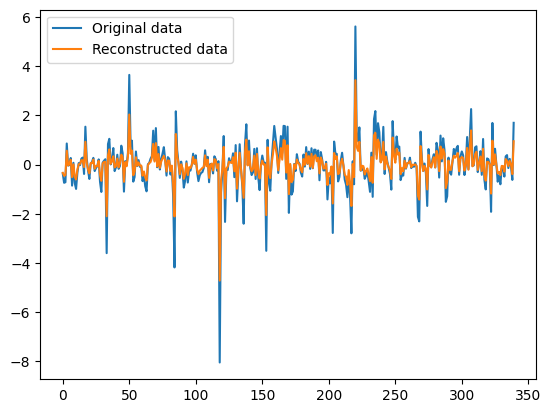

In [19]:
# Assume X and X_reconstructed are 1D arrays. If they are not, you may need to reshape them.
plt.plot(X_train_FTSE, label='Original data')
plt.plot(rendimenti_ricostruiti, label='Reconstructed data')
plt.legend()
plt.show()

## Performance - Test

In [20]:
# Selezione delle colonne desiderate utilizzando il metodo loc
X_test_selected = X_test.loc[:, ftse_selected]


In [ ]:
X_test_FTSE = X_test_FTSE.values
X_test_selected = X_test_selected.values

# Risolvi il problema dei minimi quadrati per trovare w
w_test, residuals, rank, singular_values = np.linalg.lstsq(X_test_selected, X_test_FTSE, rcond=None)
w_test = w_test/np.sum(w_test)

In [ ]:
rendimenti_ricostruiti_test = np.dot(X_test_selected,w_test)

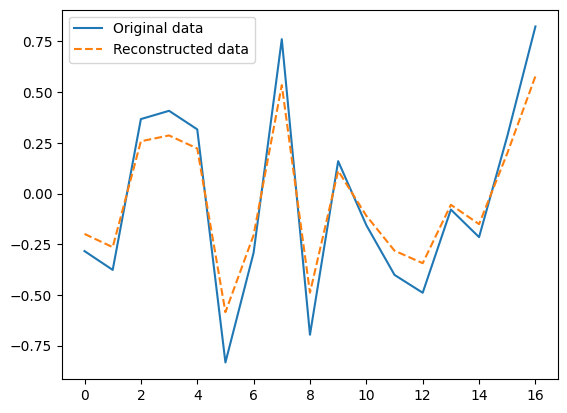

In [ ]:
# Assume X and X_reconstructed are 1D arrays. If they are not, you may need to reshape them.
plt.plot(X_test_FTSE, label='Original data')
plt.plot(rendimenti_ricostruiti_test, label='Reconstructed data', linestyle = 'dashed')
plt.legend()
plt.show()